In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('kc_house_data.csv')
df.isnull().sum()   

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [2]:
for col in ['sqft_lot','bathrooms']:
    df.loc[
        df.sample(frac=0.05,random_state=42).index, col
    ]=np.nan

In [3]:
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms        1081
sqft_living         0
sqft_lot         1081
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          2
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

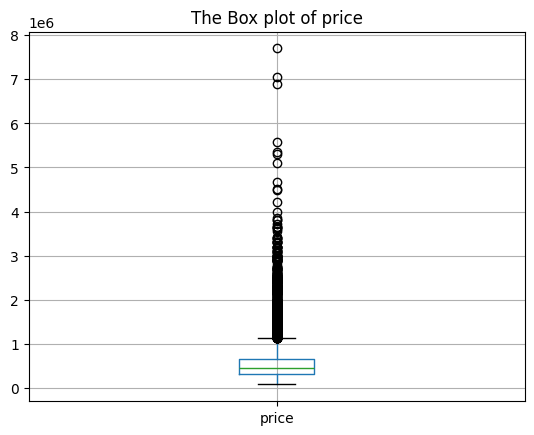

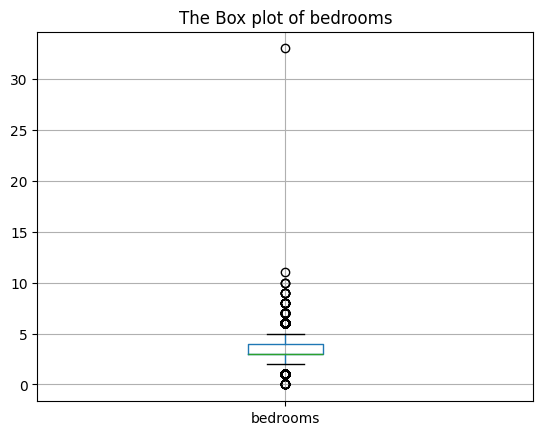

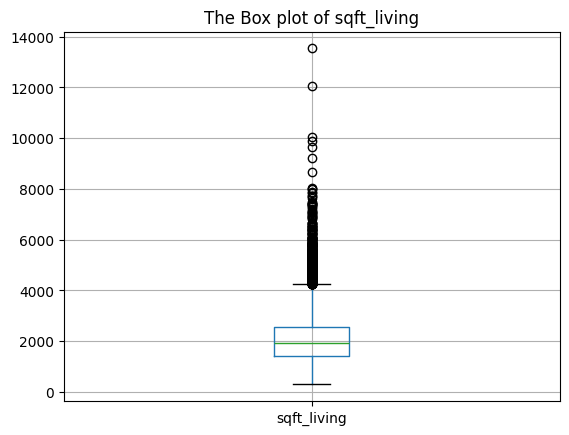

In [4]:
data=['price','bedrooms','sqft_living']
for i in data:
    df.boxplot(column=[i])
    plt.title(f"The Box plot of {i}")
    plt.show()

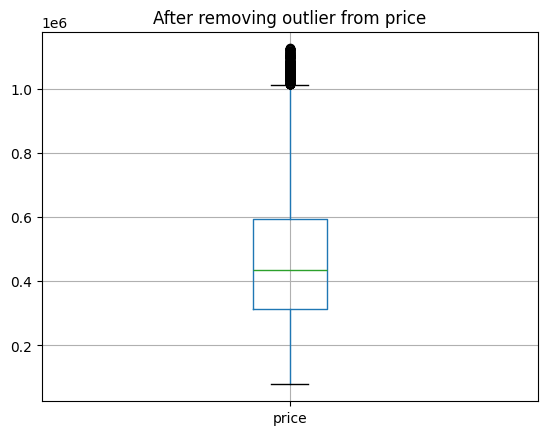

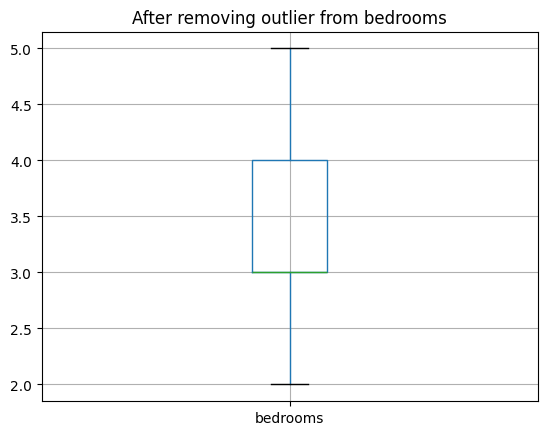

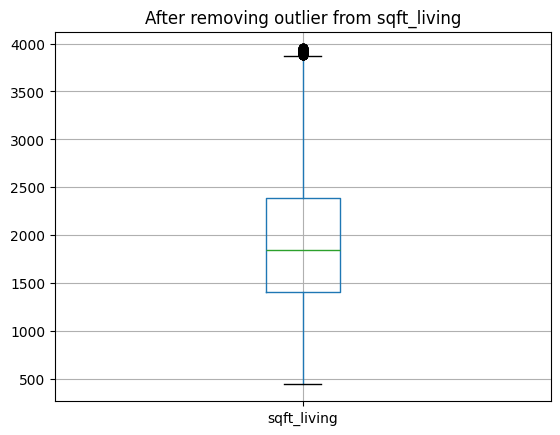

In [5]:
def remove_outlier(df,col):
    q1=df[col].quantile(0.25)
    q3=df[col].quantile(0.75)
    iqr=q3-q1

    lower_bound=q1-1.5 *iqr
    upper_bound=q3+1.5 *iqr
    
    return df[(df[col] <= upper_bound) & (df[col]>=lower_bound)]   

for i in data:
    df=remove_outlier(df,i)

for i in data:
    plt.title(f"After removing outlier from {i}")
    df.boxplot(column=[i])
    plt.show()


In [6]:
#converting date to datetime object
df['date']=pd.to_datetime(df['date'])

#sale_year: The year the house was sold
df['sale_year']= df['date'].dt.year

# sale_month: The month the house was sold.
df['sale_month']=df['date'].dt.month

# house_age: The age of the house at the time of sale (sale_year -
# yr_built).
df['house_age']=df['sale_year']-df['yr_built']

df[['date','sale_year','sale_month','house_age']].head()

,date,sale_year,sale_month,house_age
0,2014-10-13,2014,10,59
1,2014-12-09,2014,12,63
2,2015-02-25,2015,2,82
3,2014-12-09,2014,12,49
4,2015-02-18,2015,2,28


In [7]:
# Renovation Status:
# ■ was_renovated: A binary feature (1 if yr_renovated is not 0,
# else 0).
df['was_renovated']=df['yr_renovated'].apply(lambda x:1 if x!=0 else 0)

# ■ age_since_renovation: Years since renovation. If never
# renovated, this could be the same as house_age. Think about the
# best way to handle this.
df['age_since_renovation']=df.apply(
    lambda renovation: renovation['sale_year']-renovation['yr_renovated'] if renovation['was_renovated']==1 
    else renovation['house_age'],
    axis=1
)

df[['was_renovated','age_since_renovation','yr_renovated','house_age']].head()

,was_renovated,age_since_renovation,yr_renovated,house_age
0,0,59,0,59
1,1,23,1991,63
2,0,82,0,82
3,0,49,0,49
4,0,28,0,28


In [8]:
# Ratio Features: Create at least two insightful ratio features. For
# example:
# ■ sqft_living_per_floor: sqft_living / floors. (Handle cases where
# floors might be 0).
# ■ bath_per_bed: bathrooms / bedrooms. (Handle cases where
# bedrooms might be 0).
df['sqft_living_per_floor']=df.apply(
    lambda r:r['sqft_living']/r['floors'] if r['floors']>0
    else r['sqft_living'], axis=1
)

df['bath_per_bed']=df.apply(
    lambda r:r['bathrooms']/r['bedrooms'] if r['bedrooms']>0
    else r['bathrooms'], axis=1
)

df['bedrooms_per_floor']=df.apply(
    lambda r:r['bedrooms']/r['floors'] if r['floors']>0
    else r['bedrooms'], axis=1
)
df[['sqft_living_per_floor','bath_per_bed','bedrooms_per_floor']].head()

,sqft_living_per_floor,bath_per_bed,bedrooms_per_floor
0,1180.0,0.333333,3.0
1,1285.0,0.750000,1.5
2,770.0,0.500000,2.0
3,1960.0,0.750000,4.0
4,1680.0,0.666667,3.0


In [9]:
# Task 2 
# 1. Identify Feature Types: After your feature engineering in Task 1, categorize your final 
# columns into three groups: 
# ○ Numerical Features: Continuous variables that need imputation 
# and scaling (e.g., sqft_living, house_age, sqft_lot). 
# ○ Categorical Features: Features that should be treated as categories, not numbers (e.g., zipcode). 
# ○ Passthrough Features: Features you believe don't need scaling or encoding but are still useful (e.g., grade, condition, was_renovated).
numerical_features=['bedrooms','bathrooms','sqft_living',
       'sqft_lot', 'floors','sqft_above', 'sqft_basement',
       'lat','long','sqft_living15', 'sqft_lot15','house_age','age_since_renovation',
       'sqft_living_per_floor', 'bath_per_bed', 'bedrooms_per_floor'
       ]

categorical_features=['zipcode','waterfront', 'view']

passthrough_features=['condition', 'grade','sale_year', 'sale_month','was_renovated']

In [10]:
# 2. Create Preprocessing Pipelines for Each Type:
    # ○ Numerical Pipeline: Create a Pipeline that first imputes missing values
    # (using SimpleImputer with a median strategy) and then scales the data
    # (using StandardScaler).
    #  Categorical Pipeline: Create a Pipeline that applies OneHotEncoder to
    # the zipcode column. Set handle_unknown='ignore' to prevent errors if
    # the test set contains a zipcode not seen in the training set.
# Combine Pipelines with ColumnTransformer:
    # ○ Use ColumnTransformer to apply your numerical pipeline to the
    # numerical columns, your categorical pipeline to the categorical
    # columns, and specify 'passthrough' for the passthrough columns.
    # ○ This ColumnTransformer will be the first step in your final modeling
    # pipeline.

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_pipline=Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('scaler',StandardScaler())
])

category_pipeline=Pipeline([
    ('encoder',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor=ColumnTransformer([
    ('num',num_pipline,numerical_features),
    ('cat',category_pipeline,categorical_features),
    ('pass','passthrough',passthrough_features),
    
])

X=df.drop('price',axis=1)
y=df['price']

# preprocessor.fit(X)
# X_transformed_data=preprocessor.transform(X)

# print(X_transformed_data.shape)
# print(X_transformed_data)

In [11]:
# Task 3: Model Training and Hyperparameter Tuning
# Now, find the best possible model by tuning its hyperparameters.
# 1. Select Candidate Models: Based on the results from the original notebook,
# choose the top 3 performing models (e.g., Gradient Boosting, XGBoost,
# Random Forest).

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

ridge_pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',Ridge(random_state=42))
])

gb_pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',GradientBoostingRegressor(random_state=42))
])

xg_pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',XGBRegressor(random_state=42,eval_metric='rmse'))
])


In [12]:
# 2. Hyperparameter Tuning with GridSearchCV:
# ○ For each of your three final pipelines, define a parameter grid
# (param_grid) to search. For the regressor step, remember to prefix the
# parameter names with regressor__ (e.g., 'regressor__n_estimators':
# [100, 200]).
# ○ Choose at least two parameters to tune for each model.
# ○ Use GridSearchCV with 3 fold cross-validation (cv=3) to find the best
# set of hyperparameters for each model.
# ○ Train GridSearchCV on the full training data. It will automatically
# handle applying the preprocessing pipeline correctly during
# cross-validation.

# Ridge
ridge_param_grid={
    'regressor__alpha': [0.01,0.1,1,10,100],
}
# Gradient Boosting
gb_param_grid={
    'regressor__n_estimators':[100,200],
    'regressor__learning_rate':[0.01,0.05],
    'regressor__max_depth':[3,5],
}
# XgBoost
xg_param_grid={
    'regressor__n_estimators':[100,200],
    'regressor__learning_rate':[0.01,0.05],
    'regressor__max_depth':[3,5],
}

In [15]:
from sklearn.model_selection import GridSearchCV,train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

gb_grid=GridSearchCV(gb_pipeline,gb_param_grid,cv=3,n_jobs=-1,scoring='r2',verbose=2)
gb_grid.fit(X_train,y_train)
print("Best Gradient Boosting params:",gb_grid.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Gradient Boosting params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}


In [17]:
xg_grid=GridSearchCV(xg_pipeline,xg_param_grid,cv=3,n_jobs=-1,scoring='r2',verbose=2)
xg_grid.fit(X_train,y_train)
print("Best XGBoost params:",xg_grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGBoost params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}


In [14]:
ridge_grid=GridSearchCV(ridge_pipeline,ridge_param_grid,cv=3,n_jobs=-1,scoring='r2',verbose=2)
ridge_grid.fit(X_train,y_train)
print("Best Ridge params:",ridge_grid.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Ridge params: {'regressor__alpha': 0.01}


In [19]:
# Task 4: Evaluation and Interpretation
# Finally, evaluate your best model and interpret its results.
# 1. Final Evaluation:
# ○ Identify the best overall model and its parameters from your
# GridSearchCV results.

print(ridge_grid.best_score_
,gb_grid.best_score_
,xg_grid.best_score_)

0.8379905422242947 0.8687394052075593 0.8673527847310277


In [20]:
best_model_name=None
best_grid=None
best_score=-float("inf")

grids={'Ridge':ridge_grid,'GradientBoosting':gb_grid,'XGBoost':xg_grid}

for name,grid in grids.items():
    if grid.best_score_>best_score:
        best_score=grid.best_score_
        best_model_name=name
        best_grid=grid
        
print(f"Best Model: {best_model_name}")
print(f"Best parameters: {best_grid.best_params_}")
        

Best Model: GradientBoosting
Best parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}


In [22]:
# Evaluate this best tuned pipeline on the test set.
# ○ Report the final R2 score, Mean Absolute Error (MAE), and Root
# Mean Squared Error (RMSE).

from sklearn.metrics import r2_score,mean_absolute_error,root_mean_squared_error

# og model
gb_pipeline.fit(X_train,y_train)
y_pred_og=gb_pipeline.predict(X_test)
og_rmse=root_mean_squared_error(y_test,y_pred_og)
print(f"Original GradientBoosting RMSE: {og_rmse:.2f}")

# best tuned model
y_pred=best_grid.best_estimator_.predict(X_test)

r2=r2_score(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
rmse=root_mean_squared_error(y_test,y_pred)

print("Final Test Set Evaluation")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Original GradientBoosting RMSE: 81717.04
Final Test Set Evaluation
R2: 0.8672
MAE: 52585.67
RMSE: 73901.07


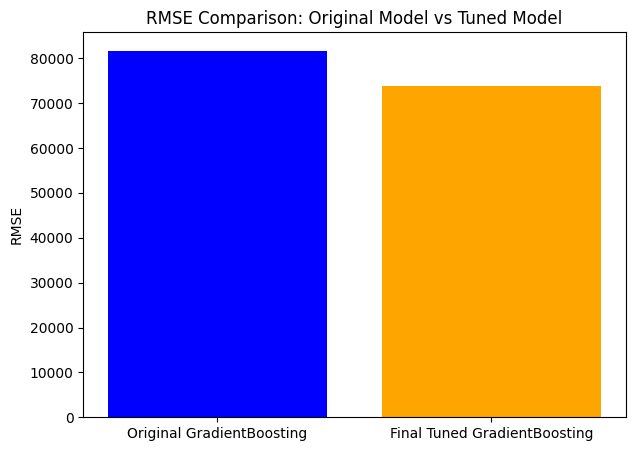

In [26]:
comparison=pd.DataFrame({
    'Model':['Original GradientBoosting','Final Tuned GradientBoosting'],
    'RMSE':[og_rmse,rmse]
})

plt.figure(figsize=(7,5))
plt.bar(comparison['Model'],comparison['RMSE'],color=['blue','orange'])
plt.ylabel('RMSE')
plt.title('RMSE Comparison: Original Model vs Tuned Model')
plt.show()

In [28]:
percentage_improvement=(og_rmse-rmse)/og_rmse * 100
print(f"Percentage improvement in RMSE: {percentage_improvement:.2f}%")

Percentage improvement in RMSE: 9.56%


In [31]:
best_model=gb_grid.best_estimator_

num_features=numerical_features

cat_features=best_model.named_steps['preprocessor']\
    .named_transformers_['cat']['encoder']\
    .get_feature_names_out(categorical_features)
    
pass_features=passthrough_features

all_features=np.concatenate([num_features,cat_features,pass_features])

In [33]:
regressor=best_model.named_steps['regressor']
feature_imp=regressor.feature_importances_

feat_imp_dif=pd.DataFrame({
    'feature':all_features,
    'feature_importance':feature_imp
}).sort_values(by='feature_importance',ascending=False)

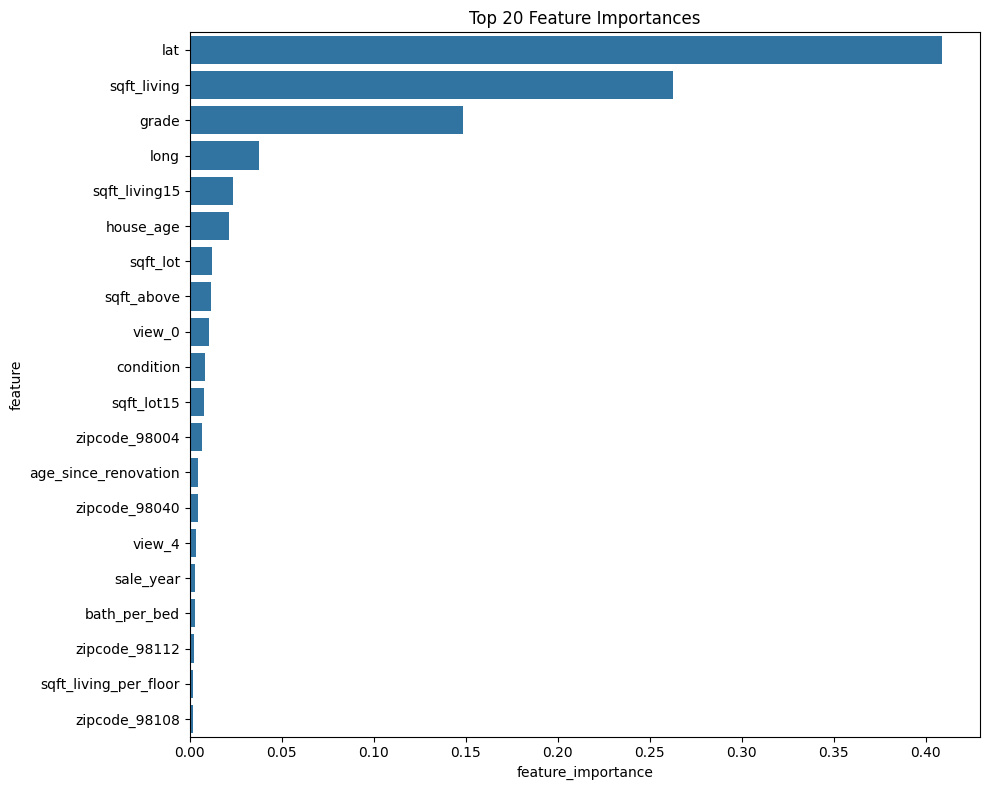

In [34]:
top_n=20
plt.figure(figsize=(10,8))
sns.barplot(x='feature_importance',y='feature',data=feat_imp_dif.head(top_n))
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

In [36]:
print("Top 5 most important features: ")
print(feat_imp_dif.head(5))

Top 5 most important features: 
          feature  feature_importance
7             lat            0.409145
2     sqft_living            0.262725
94          grade            0.148600
8            long            0.037679
9   sqft_living15            0.023197


In [39]:
print('''
      Top 5 most important features helps us evaluate that
      latitude and longitude: location is huge factor in house prices.
      sqft_living: It determines that as the size of houses increases prices also increases.
      grade: reflects the design quality and overall construction which impacts the price.
      sqft_living15- the living area of nearby houses, and neighborhood house sizes and price based on that.
      
      None of the top 5 are explicitly engineered features.
''')


      Top 5 most important features helps us evaluate that
      latitude and longitude: location is huge factor in house prices.
      sqft_living: It determines that as the size of houses increases prices also increases.
      grade: reflects the design quality and overall construction which impacts the price.
      sqft_living15- the living area of nearby houses, and neighborhood house sizes and price based on that.

      None of the top 5 are explicitly engineered features.

